# Minimum Entropy Loss
https://discuss.pytorch.org/t/calculating-the-entropy-loss/14510

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('dark_background')
π = np.pi
from numpy.random import uniform as uni
from tqdm import tqdm

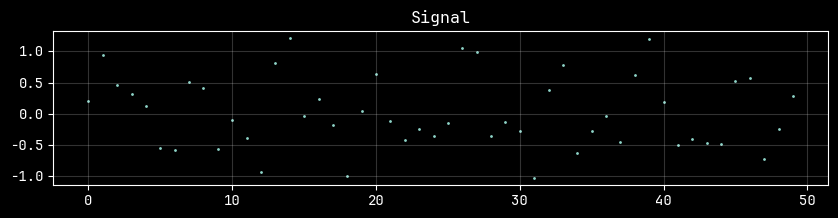

In [24]:
# generate a random signal as a sum of random frequencies
N_FREQS = 5
N_SAMPLES = 50

# generate random frequencies
fs = uni(0, N_SAMPLES/20, N_FREQS)
As = uni(0, 1, N_FREQS)
φs = uni(0, 2*π, N_FREQS)
t = np.arange(N_SAMPLES)

# generate the signal
x = np.sum([As[i]*np.sin(2*π*fs[i]*t+φs[i]) for i in range(N_FREQS)], axis=0)
# x = uni(-uni(.2, 1.2), +uni(.2, 1.2), N_SAMPLES)

#plot the signal
plt.figure(figsize=(10, 2))
plt.scatter(t,x, s=1)
plt.title('Signal')
plt.show()

levels: [-1.5  -1.35 -1.2  -1.05 -0.9  -0.75 -0.6  -0.45 -0.3  -0.15  0.    0.15
  0.3   0.45  0.6   0.75  0.9   1.05  1.2   1.35  1.5 ]
number of levels: 19
levels: [-0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
number of levels: 8


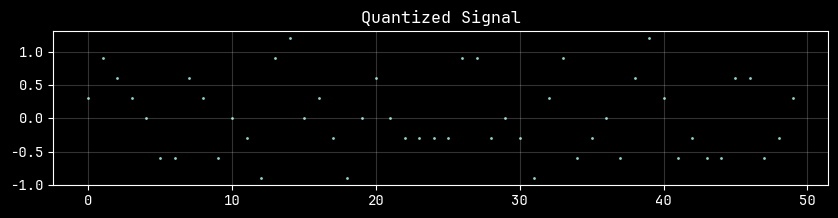

In [25]:
# quantize the signal
EPSI = 0.15

nlevels = 1+np.ceil(np.max(np.abs(x))/EPSI)
levels = EPSI*np.arange(-nlevels, nlevels+1)
nlevels = int(1+2*np.ceil(np.max(np.abs(x))/EPSI))
print(f'levels: {levels}')
print(f'number of levels: {nlevels}')

# def quantize(x, ε): return ε*np.round(x/ε) 
def quantize(x, ε): return 2*ε*np.round(x/(2*ε)) 

xq = quantize(x, EPSI)

print(f'levels: {np.unique(xq)}')
print(f'number of levels: {np.unique(xq).shape[0]}')

# plot the quantized signal
plt.figure(figsize=(10, 2))
# plt.plot(t,x, label='original')
plt.scatter(t,xq, label='quantized', s=1)
plt.title('Quantized Signal')
plt.show()

In [26]:
# measure entropy of the signal
def entropy(x):
    _, counts = np.unique(x, return_counts=True)
    p = counts/len(x)
    # return -np.sum(p*np.log2(p))
    return -np.sum(p*np.log(p))

print(f'Entropy of the quantized signal: {entropy(xq):.2f}')

Entropy of the quantized signal: 1.97


In [27]:
class HLoss(nn.Module):
    def __init__(self):
        super(HLoss, self).__init__()

    def forward(self, x):
        assert x.size(-1) == nlevels, f'x.size: {x.size()}'
        b = F.softmax(x, dim=-1) * F.log_softmax(x, dim=-1)
        b = -1.0 * b.sum()
        return b

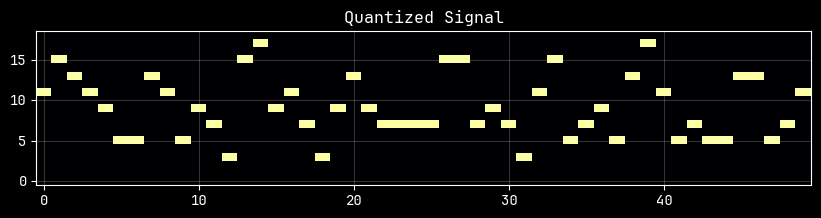

In [28]:
# convert the signal to a tensor
xqt = torch.tensor(xq/EPSI + nlevels//2, dtype=torch.int64)
# #convert to a vector of 1-hot encoded values
xq_1hot = F.one_hot(xqt, num_classes=nlevels)
# plot the 2dmatrix 
plt.figure(figsize=(10, 2))
plt.imshow(xq_1hot.T, aspect='auto', interpolation='none', origin='lower')
plt.title('Quantized Signal')
plt.show()

In [29]:
# calculate entropy
hloss = HLoss()
h = hloss(xq_1hot.to(torch.float32).unsqueeze(0))/N_SAMPLES
print(f'Entropy of the quantized signal: {h:.2f}')

Entropy of the quantized signal: 2.90


# ENTROPY IS NOT DIFFERENTIABLE
## But apparently these mutherfuckers found a way to do it
$$
 \frac{\partial{H}}{\partial{r_i}} = \lim_{b \to \infty} \sum_{j=0}^{|S|} [1 + \ln p(s_j)] * R(r_i - s_j)
$$

with $R$:

$$
R(r_i - s_j) = \frac{b}{|r|\varepsilon^b} \frac{(r_i - s_j)^{b-1}}{\left[\frac{(r_i -
s_j)^b}{\varepsilon^b} + 1\right]^2} $$

Master thesis version:

$$ 
R = \frac{b}{\left( \text{size}(rq) \cdot \varepsilon^b \right)} \cdot \frac{(rq - s_j)^{b-1}}{\left( \frac{(rq - s_j)^b}{\varepsilon^b} + 1 \right)^2}
$$

In [30]:
# see what this fucking function actually looks like
# def dentropy(r, b=10, ε=0.1):
#     symbols, counts = np.unique(r, return_counts=True)
#     p = counts/len(r)
#     log2p = np.log2(p)
#     H = -np.sum(p*log2p) # entropy
#     sizer = len(r)
#     print(f'sizer: {sizer}')

#     DH = np.zeros_like(r)
#     for i in range(len(r)):
#         dhi = 0
#         for j in range(len(symbols)):
#             a1 = (1 + log2p[j] + 1e-8)
#             print(f'1: {a1}')
#             a2 = b / (sizer * ε**b)
#             print(f'2: {a2}')
#             a3 = ( r[i] - symbols[j] )**(b-1) 
#             print(f'3: {a3}')
#             a4 = (((r[i]-symbols[j])/ε)**b + 1)**2
#             print(f'4: {a4}')
#             dhi += a1 * a2 * a3
#             print(f'comb: {a1*a2*a3/a4}\n')
#         DH[i] = dhi
#     return H, DH

def dentropy(rq, b=10.0, ε=0.1):
    print(f'rq: {rq}')
    symbols, counts = np.unique(rq, return_counts=True)
    print(f'symbols: {symbols}')
    print(f'counts: {counts}')
    p = counts/len(rq)
    # logp = np.log2(p + 1e-8)
    logp = np.log(p + 1e-8)
    H = -np.sum(p*logp) # entropy
    sizer = len(rq)
    print(f'sizer: {sizer}')

    DH = 0
    for j in range(len(symbols)):
        a1 = (1 + logp[j])
        print(f'1: {a1}')
        a2 = b / (float(sizer) * ε**b)
        print(f'2: {a2:.3e}, {ε**b:.3e}, {ε}, {b}')
        a3 = ( rq - symbols[j] )**(b-1) 
        print(f'3: {a3}')
        a4 = (((rq-symbols[j])/ε)**b + 1)**2
        print(f'4: {a4}')
        DH += a1 * a2 * a3 / a4
        print(f'comb: {a1*a2*a3/a4}\n')
        break

    return H, DH

H, DH = dentropy(xq, b=10, ε=EPSI)

        





rq: [ 0.3  0.9  0.6  0.3  0.  -0.6 -0.6  0.6  0.3 -0.6 -0.  -0.3 -0.9  0.9
  1.2 -0.   0.3 -0.3 -0.9  0.   0.6 -0.  -0.3 -0.3 -0.3 -0.3  0.9  0.9
 -0.3 -0.  -0.3 -0.9  0.3  0.9 -0.6 -0.3 -0.  -0.6  0.6  1.2  0.3 -0.6
 -0.3 -0.6 -0.6  0.6  0.6 -0.6 -0.3  0.3]
symbols: [-0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
counts: [ 3  9 11  7  7  6  5  2]
sizer: 50
1: -1.8134105500933835
2: 3.468e+07, 5.767e-09, 0.15, 10
3: [5.160e+00 1.984e+02 3.844e+01 5.160e+00 3.874e-01 1.968e-05 1.968e-05
 3.844e+01 5.160e+00 1.968e-05 3.874e-01 1.008e-02 0.000e+00 1.984e+02
 7.943e+02 3.874e-01 5.160e+00 1.008e-02 0.000e+00 3.874e-01 3.844e+01
 3.874e-01 1.008e-02 1.008e-02 1.008e-02 1.008e-02 1.984e+02 1.984e+02
 1.008e-02 3.874e-01 1.008e-02 0.000e+00 5.160e+00 1.984e+02 1.968e-05
 1.008e-02 3.874e-01 1.968e-05 3.844e+01 7.943e+02 5.160e+00 1.968e-05
 1.008e-02 1.968e-05 1.968e-05 3.844e+01 3.844e+01 1.968e-05 1.008e-02
 5.160e+00]
4: [1.153e+18 3.834e+21 1.000e+20 1.153e+18 3.656e+15 1.051e+06 1.051e+06
 1.

In [31]:
# master thesis version in tensorflow
import tensorflow as tf
np.set_printoptions(precision=3)



def quantized_entropy_loss(epsilon,b=10.0):
  
  @tf.custom_gradient
  def loss_func(r):
    
    #Quantization
    rq = tf.cast((2*epsilon) * tf.math.round(r/(2*epsilon)), dtype=tf.float64) #epsilon is the quantization step


    # Calculate entropy
    unique_rq, _, count_rq = tf.unique_with_counts(tf.reshape(rq, [-1]))

    # sort the unique values
    unique_rq, count_rq = zip(*sorted(zip(unique_rq, count_rq)))
    unique_rq = tf.convert_to_tensor(unique_rq)
    count_rq = tf.convert_to_tensor(count_rq)

    print(f'unique_rq: {unique_rq}')
    print(f'count_rq: {count_rq}')

    p_rq = count_rq / tf.reduce_sum(count_rq) #probability of each unique residual
    QEL = tf.cast( -tf.reduce_sum(p_rq * tf.math.log(p_rq + 1e-8)), dtype=tf.float32)

    #Gradient approximation
    def R(rq, sj, b=b, epsilon=epsilon):
      a2 = b / (tf.cast(tf.size(rq), dtype=tf.float64) * epsilon**b)
      print(f'a2: {a2:.3e}, {epsilon**b:.3e}, {epsilon}, {b}')
      a3 = ((rq - sj)**(b-1))
      print(f'a3: {a3}')
      a4 = (((rq - sj)**b / epsilon**b) + 1)**2
      # ret1 = (b / (tf.cast(tf.size(rq), dtype=tf.float64) * epsilon**b)) * ((rq - sj)**(b-1)) / (((rq - sj)**b / epsilon**b) + 1)**2
      ret2 = a2 * a3 / a4
      return ret2
    def grad(upstream):
      gradient_approx = 0.0 #dH/dr
      for sj,pj in zip(unique_rq, p_rq):
        a1 = (1 + tf.math.log(pj + 1e-8))
        print(f'a1: {a1}')
        g_increment = a1 * R(rq,sj)
        gradient_approx += g_increment
        break
      print(f'gradient_approx: {gradient_approx}')
      return upstream * tf.cast(gradient_approx, dtype=tf.float32)
    
    return QEL, grad

  return loss_func

# test the function on x
xtf = tf.constant(x, dtype=tf.float32)
# qel = quantized_entropy_loss(EPSI, b=10)(xtf)

# calculate the gradient
with tf.GradientTape() as tape:
    tape.watch(xtf)
    qel = quantized_entropy_loss(EPSI, b=10)(xtf)
dqel_dx = tape.gradient(qel, xtf)


print(f'Entropy of the quantized signal: {qel:.2f}')


unique_rq: [-0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 3  9 11  7  7  6  5  2]
a1: -1.8134105500933835
a2: 3.468e+07, 5.767e-09, 0.15, 10
a3: [5.160e+00 1.984e+02 3.844e+01 5.160e+00 3.874e-01 1.968e-05 1.968e-05
 3.844e+01 5.160e+00 1.968e-05 3.874e-01 1.008e-02 0.000e+00 1.984e+02
 7.943e+02 3.874e-01 5.160e+00 1.008e-02 0.000e+00 3.874e-01 3.844e+01
 3.874e-01 1.008e-02 1.008e-02 1.008e-02 1.008e-02 1.984e+02 1.984e+02
 1.008e-02 3.874e-01 1.008e-02 0.000e+00 5.160e+00 1.984e+02 1.968e-05
 1.008e-02 3.874e-01 1.968e-05 3.844e+01 7.943e+02 5.160e+00 1.968e-05
 1.008e-02 1.968e-05 1.968e-05 3.844e+01 3.844e+01 1.968e-05 1.008e-02
 5.160e+00]
gradient_approx: [-2.815e-10 -3.254e-12 -2.418e-11 -2.815e-10 -6.665e-09 -1.178e-03
 -1.178e-03 -2.418e-11 -2.815e-10 -1.178e-03 -6.665e-09 -5.765e-07
  0.000e+00 -3.254e-12 -5.971e-13 -6.665e-09 -2.815e-10 -5.765e-07
  0.000e+00 -6.665e-09 -2.418e-11 -6.665e-09 -5.765e-07 -5.765e-07
 -5.765e-07 -5.765e-07 -3.254e-12 -3.254e-12 -5.765e-0

## Let's see if there is correlation between the softmax differentiable function and the real entropy

  0%|          | 0/2000 [00:00<?, ?it/s]

unique_rq: [-2.1 -1.8 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [1 2 7 5 5 6 4 5 2 4 2 4 1 2]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 1 5 2 8 4 8 5 4 5 5 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1  2.4]
count_rq: [1 2 3 6 4 6 5 9 4 4 2 2 1 1]
unique_rq: [-2.1 -1.8 -1.5 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [1 1 1 7 4 7 8 6 6 4 1 2 1 1]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [2 3 2 5 6 3 4 8 4 6 2 4 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  3  1  3  4  6 10  9  4  6  3]
unique_rq: [-0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 3 11 10  7  7  5  4  3]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  2  3  4 13  8  4  6  6  3]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  4 11  7  3 12  7  4  1]
un

  1%|▏         | 25/2000 [00:00<00:08, 246.15it/s]

unique_rq: [-2.7 -2.1 -1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1  2.4]
count_rq: [1 1 4 2 5 4 5 5 4 5 6 2 3 1 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 2 6 8 5 5 5 5 6 3 3]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8]
count_rq: [2 2 1 6 5 5 5 5 6 4 6 1 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 1  1  5  7  7  8  6 10  3  1  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 3 2 7 5 4 6 4 1 7 6 2 1]
unique_rq: [-2.1 -1.8 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [ 1  2  4  4  3  9  4  4  4 11  2  1  1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.7]
count_rq: [1 4 4 2 3 3 6 4 4 9 1 4 4 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [2 6 2 3 2 2 2 6 4 6 6 2 4 2 1]
unique_rq: [-2.4 -2.1 -1.

  3%|▎         | 52/2000 [00:00<00:07, 254.19it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [ 2  3  3  3  5  7  4  3 10  5  2  1  1  1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 1 1 6 8 5 5 4 7 5 2 2 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 4 7 3 5 6 9 6 4 3 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 2 5 3 3 7 7 4 3 5 5 3 1]
unique_rq: [-1.8 -1.5 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  2  3  5 12  5  8  6  6  2]
unique_rq: [-2.4 -2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1
  2.4]
count_rq: [1 1 4 4 4 3 4 6 3 7 7 3 1 1 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8]
count_rq: [ 3  2  7  7 14  8  3  3  2  1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  4  1  3  4 10  1 10  3  5  5  2  1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.

  4%|▍         | 80/2000 [00:00<00:07, 263.14it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  2  4  5  5  4  6 10  2  3  3  1  4]
unique_rq: [-1.8 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  4  3  4  9  8 10  4  2  1  3  1]
unique_rq: [-0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [ 2  3 15 11 10  7  2]
unique_rq: [-2.4 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 3 5 1 5 4 7 6 8 2 6 1 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.3  0.6  0.9  1.2]
count_rq: [7 6 4 8 7 5 5 8]
unique_rq: [-3.  -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2
  1.5  1.8  2.1  2.7]
count_rq: [1 2 2 2 1 3 2 3 4 5 2 5 8 2 2 3 2 1]
unique_rq: [-3.  -2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  2.1  2.4]
count_rq: [1 2 2 2 4 4 6 6 4 4 6 5 2 2]
unique_rq: [-1.5 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 2  7  3  7 10  7 10  2  1  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 3  3  7

  5%|▌         | 108/2000 [00:00<00:07, 269.22it/s]

unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 2 2 3 4 7 9 6 2 5 3 3 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 3 6 5 8 3 4 9 6 2 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  1.2  1.5]
count_rq: [ 2  3  4  5  7  7  7 10  3  2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  1  5  5  3  5  6 13  4  1  1  2  3]
unique_rq: [-2.1 -1.8 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [1 2 3 6 5 8 9 3 5 3 3 1 1]
unique_rq: [-2.4 -2.1 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [ 1  1  2  4 10  9  2  4  4  5  3  4  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 2  3  4  5  8 10  5  6  2  2  1  2]
unique_rq: [-2.1 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1  2.4]
count_rq: [ 1  2  3  2  3  1  4 10  7  3  8  3  2  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2

  7%|▋         | 135/2000 [00:00<00:07, 256.14it/s]

unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 4  2  8 11 10  4  5  3  2  1]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1  2.4  2.7]
count_rq: [1 2 1 5 2 1 6 4 8 6 4 2 3 1 1 1 1 1]
unique_rq: [-0.9 -0.6 -0.3 -0.   0.3  0.6]
count_rq: [ 1  6 13 14 12  4]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1  2.4]
count_rq: [1 6 2 8 5 8 6 2 5 2 2 1 1 1]
unique_rq: [-2.4 -2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8  2.4
  2.7]
count_rq: [2 1 1 1 6 8 4 2 6 6 4 4 3 1 1]
unique_rq: [-2.7 -2.4 -2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8
  2.1]
count_rq: [1 1 1 3 4 2 4 5 6 9 7 2 2 2 1]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 3 5 7 3 9 4 7 5 2 2 1]
unique_rq: [-2.1 -1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 2 2 4 6 6 7 5 7 3 4 1 2]
unique_rq: [-1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  

  8%|▊         | 161/2000 [00:00<00:07, 253.16it/s]

unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2
  1.5  2.1]
count_rq: [1 1 1 2 4 2 5 2 1 6 2 6 7 4 5 1]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [ 1  4  2  3  5  7 10  3  5  2  3  4  1]
unique_rq: [-2.7 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1]
count_rq: [1 1 1 2 4 6 3 7 3 2 6 7 2 2 1 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [ 2  2  3  2  5  7  3  6  6 14]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [3 5 6 8 9 7 3 2 5 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [1 3 3 4 4 8 5 4 4 6 2 4 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [3 2 5 8 5 6 8 3 5 4 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [7 7 3 5 8 2 7 6 3 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.

  9%|▉         | 189/2000 [00:00<00:06, 260.26it/s]

unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [ 1  6 10  8  1  8  7  9]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2
  1.5  1.8]
count_rq: [1 1 1 3 6 2 3 4 2 3 3 5 4 4 5 3]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  2.1]
count_rq: [ 1  1  2  1  3  5  2  5 10  2  3  6  3  4  2]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [3 7 4 7 9 7 9 4]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8  2.4
  2.7]
count_rq: [4 1 2 2 3 5 3 7 8 5 3 2 3 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [4 3 3 7 5 4 8 5 2 6 2 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [ 1  2  5  3 11  6  8  3  6  2  2  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [3 2 6 7 3 6 6 4 8 3 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 2  

 11%|█         | 216/2000 [00:00<00:06, 261.13it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 3 2 4 8 7 6 5 5 5 1 3]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8
  2.1  2.4]
count_rq: [2 1 1 2 5 2 3 4 5 7 4 6 3 3 1 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 1  1  3  1  3  3  6  5 17  3  2  3  2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [1 3 4 3 6 5 3 5 7 3 5 4 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [2 6 6 8 7 7 7 7]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2
  1.8  2.1]
count_rq: [2 1 3 2 4 5 1 7 8 4 4 4 2 1 1 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1  2.4]
count_rq: [2 3 1 3 3 1 3 3 5 3 7 5 4 2 2 3]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [1 1 4 3 8 9 5 4 5 3 2 2 2 1]
unique_rq: [-2.4 -1.8 -1.5 -

 12%|█▏        | 243/2000 [00:00<00:06, 261.90it/s]

unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 2  4  7  3  7  4  6  4 11  2]
unique_rq: [-0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [ 2  6 12 14  9  2  5]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 4 2 4 5 6 6 4 4 7 3 1 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [2 2 4 6 6 6 9 7 7 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 4 1 4 5 7 7 5 6 3 2 5]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 2 5 3 5 5 8 4 4 4 6 1 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [ 2  2  1  4  3  7 10  5  3  4  5  1  2  1]
unique_rq: [-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7]
count_rq: [1 1 1 1 3 2 2 5 3 3 4 4 7 2 1 3 1 4 1 1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  

 14%|█▎        | 272/2000 [00:01<00:06, 268.24it/s]

unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  2  5 10  4  5  7 10  3  2  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 7 6 6 7 8 4 4 2 2 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  1.2  1.5  2.1]
count_rq: [1 1 4 4 4 4 4 5 8 3 6 3 3]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 2 2 7 6 3 5 6 4 5 3 4 1]
unique_rq: [-1.8 -1.5 -1.2 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 2  1  4  4  5 12  8  6  6  1  1]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [ 1  1  2  1 10  3  3  6  7  4  5  1  1  2  3]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2
  1.5  1.8  2.1  2.4]
count_rq: [1 1 1 2 1 3 5 2 7 5 3 9 1 3 1 2 1 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1  2.4  2.7]
count_rq: [2 3 2 3 6 5 7 2 1 

 15%|█▍        | 299/2000 [00:01<00:06, 264.10it/s]

unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 1 1 2 4 9 5 6 2 3 6 6 3]
unique_rq: [-2.7 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.4]
count_rq: [2 2 1 3 1 4 4 1 5 7 7 5 3 3 1 1]
unique_rq: [-2.4 -2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  1.2  1.5  1.8  2.1]
count_rq: [ 1  1  1  2  4  6  5 10  6  4  4  2  3  1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6]
count_rq: [ 5  6 12 14  4  7  2]
unique_rq: [-2.4 -2.1 -1.8 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [2 2 1 5 5 7 5 5 5 4 6 1 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.5  1.8  2.4  2.7]
count_rq: [1 1 3 4 9 7 5 6 4 2 4 2 1 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.4]
count_rq: [ 1  4  3  2  2  3  4  5 10  5  3  2  3  2  1]
unique_rq: [-0.9 -0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [ 7  6  8  5 10  9  5]
unique_rq: [-2.4 -2.1 -1.8 -1.2 -0.9 -0.6 -0.3 -

 16%|█▋        | 326/2000 [00:01<00:06, 261.91it/s]

unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [ 1  1  1  2  5  5 12  3  4  4  5  3  3  1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 5  2  7  6 11  5  7  3  3  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1  2.4]
count_rq: [2 1 4 2 4 4 4 8 4 7 2 3 2 1 1 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [3 3 9 9 7 9 5 3 2]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1
  2.4]
count_rq: [2 5 1 2 7 3 7 7 6 3 3 1 1 1 1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.4]
count_rq: [ 1  1  3  3  2  5 10  6  5  3  4  4  1  1  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [3 4 5 2 8 8 6 5 2 2 4 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1
  2.4]
count_rq: [1 1 4 9 4 3 5 7 5 3 1 1 4 1 1]
unique_rq: [-1.

 18%|█▊        | 354/2000 [00:01<00:06, 265.08it/s]

unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1  3. ]
count_rq: [5 5 6 5 5 2 4 5 2 3 3 2 2 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 4  4  1  3  4  5 10  3  4  4  4  3  1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 2 2 2 3 8 4 7 4 4 4 5 1 1 2]
unique_rq: [-1.8 -1.5 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [4 1 2 5 2 3 8 8 6 4 3 4]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2
  1.5  1.8  3. ]
count_rq: [1 1 1 1 3 1 4 2 7 7 6 6 4 3 1 1 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 5  7  5  2 12  4  6  3  5  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5  1.8]
count_rq: [1 5 3 7 7 3 8 4 7 3 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8  2.1]
count_rq: [2 3 7 7 4 6 3 8 1 6 2 1]
unique_rq: [-2.7 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 

 19%|█▉        | 382/2000 [00:01<00:06, 266.77it/s]

unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.9  1.2  1.5  1.8]
count_rq: [1 1 2 3 7 4 4 7 7 4 3 5 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [2 2 7 5 8 5 9 2 3 3 1 1 2]
unique_rq: [-2.7 -2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1]
count_rq: [1 1 1 2 5 4 6 3 3 7 2 5 2 5 2 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [2 6 5 3 3 1 5 6 7 1 5 4 2]
unique_rq: [-0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 4  5 13 10  7  6  4  1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  2  8  8 10  4  9  7  1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.4]
count_rq: [1 1 3 4 2 7 4 4 6 5 7 2 1 2 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 2 3 2 3 4 3 9 5 6 3 6 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_

 21%|██        | 411/2000 [00:01<00:05, 272.88it/s]

unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5]
count_rq: [ 1  3  5  8  6  5  4  6 10  2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.9  1.2  1.5  1.8
  2.1  2.4]
count_rq: [1 2 3 2 1 5 4 7 3 4 5 5 4 1 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1  2.4]
count_rq: [1 2 1 2 5 8 8 5 5 7 1 2 2 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 3 2 2 4 9 8 4 4 5 5 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5  1.8]
count_rq: [2 4 3 4 8 6 7 6 6 3 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8  2.1]
count_rq: [1 1 2 3 4 5 7 5 5 3 8 4 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [2 2 4 4 7 6 1 5 5 6 4 1 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 3 4 6 8 5 4 5 8 3 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]


 22%|██▏       | 440/2000 [00:01<00:05, 275.26it/s]

unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [ 1  2  2  2  6  2  2 11  8  3  4  2  2  2  1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 1 1 4 6 8 7 8 6 3 3 2]
unique_rq: [-2.1 -1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [ 1  1  6  4  7  5  2  4 10  4  2  2  1  1]
unique_rq: [-0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [15  7 11  2  2  4  3  6]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 2  3  7  1  2  6  4 10  3  1  4  5  2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  2.4]
count_rq: [1 1 1 2 1 5 5 9 3 7 6 1 1 5 2]
unique_rq: [-0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  6  4  9 12 11  5  2]
unique_rq: [-0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 2  5  6 10  9  5  8  4  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.9  1.2  1.5  

 23%|██▎       | 468/2000 [00:01<00:05, 276.60it/s]

unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 2 3 2 5 4 5 6 5 5 6 1 2 2 1]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.4
  2.7]
count_rq: [3 2 2 4 8 4 5 6 2 4 5 2 1 1 1]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1]
count_rq: [1 1 4 1 4 3 5 5 5 2 3 3 2 4 6 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 2 4 4 5 3 5 2 6 4 2 4 4 2 2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1  2.7]
count_rq: [2 2 1 2 1 5 8 3 3 6 7 2 3 1 2 1 1]
unique_rq: [-0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.5]
count_rq: [ 4  7 11 11  7  3  6  1]
unique_rq: [-0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [ 1  4 15  9 12  8  1]
unique_rq: [-2.4 -2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8  2.1
  3. ]
count_rq: [1 3 3 2 5 2 6 6 6 6 3 2 1 3 1]
unique_rq: [-1.8 -1.5 -

 25%|██▍       | 496/2000 [00:01<00:05, 268.38it/s]

unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 4 4 6 4 7 6 9 4 2 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [5 2 3 2 5 7 4 4 3 5 4 3 1 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [3 3 3 6 8 4 9 3 5 3 3]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 3 5 6 6 6 4 8 4 3 3]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 3  4  6  4 10  2  4  5  3  4  5]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [ 1  1  1  5  5  4 11  8  7  7]
unique_rq: [-0.9 -0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [ 4  7  9  8  8 11  3]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1  2.4]
count_rq: [2 2 5 1 1 2 7 2 5 3 5 2 2 2 3 3 3]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.7]
count_rq: [1 2 3 3 3 5 8 3 4 2 

 26%|██▌       | 524/2000 [00:01<00:05, 271.61it/s]

unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 4  3  2 14  5  8  8  4  1  1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [2 1 4 3 5 4 9 4 9 6 3]
unique_rq: [-2.7 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8
  2.1  2.7  3.6]
count_rq: [1 1 3 2 7 1 4 2 6 1 4 5 6 3 1 2 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  2 10  7 13  5  9  2  1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [2 2 3 2 9 4 6 5 6 4 2 3 2]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  3  3  4  3  1  3  5  5  6 12  1  2  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [3 1 3 3 3 4 5 6 4 4 3 5 4 2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 2 1 2 2 3 6 4 9 6 7 5 2]
unique_rq: [-0.6 -0.3 -0.   0.3  0.6]
count_rq: [ 4 10 18 1

 28%|██▊       | 552/2000 [00:02<00:05, 269.27it/s]

unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 1  7  3  4  9 12  5  4  3  1  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 3  6  5 10  2  6  8  5  4  1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 2 4 3 4 8 8 3 2 6 5 3]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 3 2 3 7 5 7 7 5 1 2 4 2]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8]
count_rq: [ 4  6  3 12  6  5  6  6  1  1]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1  2.7]
count_rq: [ 1  2  2  1  5  2  3  1  6 11  3  1  5  3  2  1  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1
  2.4]
count_rq: [1 3 1 5 4 4 8 5 6 4 3 2 2 1 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [3 3 8 7 9 8 7 2 2 1]
unique_rq: [-3.  -2.7 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0

 29%|██▉       | 580/2000 [00:02<00:05, 272.22it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8]
count_rq: [1 1 3 2 7 7 6 6 8 5 3 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8  2.1]
count_rq: [ 4  2  5  8  2  5  5 10  3  3  2  1]
unique_rq: [-2.4 -2.1 -1.8 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5  1.8  2.1
  2.4]
count_rq: [1 2 2 2 4 7 5 7 3 8 2 1 2 2 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 1 4 4 4 3 5 6 4 6 4 3 3 1 1]
unique_rq: [-2.7 -2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1  2.4  2.7]
count_rq: [1 1 2 2 3 6 5 5 6 6 3 2 2 2 1 1 1 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [3 2 1 3 3 6 2 7 7 3 6 3 3 1]
unique_rq: [-2.1 -1.5 -1.2 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 3  6  1  3  4  5 11  5  4  4  4]
unique_rq: [-0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 3  8  8 12  6  8  4  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6

 30%|███       | 608/2000 [00:02<00:05, 255.82it/s]

unique_rq: [-1.5 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 8 5 8 7 5 5 7 2 1]
unique_rq: [-1.5 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 7 5 5 3 8 5 6 6 3 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 2 1 6 5 7 8 3 3 3 3 5 2]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8  2.4]
count_rq: [1 2 3 8 6 5 5 4 3 5 3 3 2]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  2.1  2.4
  3. ]
count_rq: [1 3 2 2 2 1 4 6 6 8 9 3 1 1 1]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.6  0.9  1.2  1.5
  1.8  2.1  3.3]
count_rq: [1 1 2 4 1 2 1 7 7 5 3 5 1 5 2 2 1]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [1 4 4 3 6 3 5 6 8 3 2 2 2 1]
unique_rq: [-1.5 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  1  6 13 11  6  6  3  3]
unique_rq: [-0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [ 5  9 20  8  6

 32%|███▏      | 634/2000 [00:02<00:05, 256.69it/s]

unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 4 8 1 5 7 8 7 6 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [3 1 1 9 9 5 9 5 4 4]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [ 1  2  6 10 13  8  7  3]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 1 5 3 7 9 3 5 5 6 3 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 1  3  1  5  7  6 10  4  5  5  2  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 5 3 3 3 1 2 3 2 9 7 8 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 1 1 8 6 3 7 8 4 6 2 3]
unique_rq: [-2.4 -2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 3 5 2 3 6 5 5 8 4 4 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 2  2  5  6 10  2  4  7  4  3  3  2]
unique_rq: [-1.

 33%|███▎      | 661/2000 [00:02<00:05, 258.10it/s]

unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 2  4  7  7 10  9  8  1  2]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 2  5 10  5  4  8  6  5  5]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1  2.4]
count_rq: [1 2 2 5 4 4 7 7 5 3 1 1 1 2 4 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [3 5 4 3 5 2 2 7 3 5 4 4 1 2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8]
count_rq: [1 1 2 2 3 5 3 3 6 7 4 7 3 2 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 1 2 5 3 2 9 4 7 3 6 1 3 1 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 5 6 4 4 4 7 9 2 4 2 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [1 2 3 1 7 7 8 7 4 5 5]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq:

 34%|███▍      | 687/2000 [00:02<00:05, 251.33it/s]

unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  3  2  4  7  4 10  4  5  4  2  2  2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 1 1 7 4 6 7 9 4 4 2 3]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 3 7 6 4 5 3 9 7 2 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8  2.1]
count_rq: [2 1 4 2 7 6 4 9 2 6 4 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [1 6 5 7 6 5 7 7 5 1]
unique_rq: [-0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1  2.4  2.7]
count_rq: [2 4 3 8 7 4 7 4 6 3 1 1]
unique_rq: [-2.1 -1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [ 2  1  3  6  5  3  7  2 11  3  4  1  1  1]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2
  1.8  2.1]
count_rq: [1 1 1 1 1 2 5 5 4 7 6 6 4 3 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.

 36%|███▌      | 715/2000 [00:02<00:04, 257.76it/s]

unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.4]
count_rq: [1 1 2 2 4 5 5 6 7 4 2 5 3 2 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [ 6  6 11  3  5  9  3  7]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.4]
count_rq: [ 1  2  3  1  3  3 13  5  5  3  3  2  4  1  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  1.2  1.5  1.8  2.1
  2.4]
count_rq: [2 1 2 2 6 5 8 5 6 2 1 4 3 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [4 4 5 3 8 6 4 5 4 4 1 2]
unique_rq: [-1.8 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 4 4 5 7 8 6 7 5 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [2 4 5 6 9 5 4 4 3 2 3 2 1]
unique_rq: [-2.1 -1.8 -1.5 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.4]
count_rq: [2 2 1 4 5 9 5 6 5 5 1 3 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  

 37%|███▋      | 743/2000 [00:02<00:04, 263.26it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [ 3  3  2  4  2 11  5  3  4  4  4  3  1  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  1.2  1.5  1.8  2.4]
count_rq: [ 1  3  3  1  2  4  7 11  4  5  3  4  1  1]
unique_rq: [-1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.4]
count_rq: [3 3 3 4 8 7 4 2 7 4 3 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 2 8 9 7 5 5 4 2 1 4 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 3 3 6 8 8 5 6 5 2 1 1]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2
  1.5  1.8  2.4  3.3]
count_rq: [2 1 1 3 5 2 4 1 2 4 5 4 4 3 3 2 3 1]
unique_rq: [-2.4 -2.1 -1.8 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1  2.7]
count_rq: [3 1 1 3 5 4 6 5 4 7 2 4 1 1 1 2]
unique_rq: [-2.4 -2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1  2.4  2.7]
cou

 39%|███▊      | 771/2000 [00:02<00:04, 267.15it/s]

unique_rq: [-1.5 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 5 5 8 7 9 4 5 2 2 1]
unique_rq: [-2.1 -1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [1 2 3 8 3 7 5 6 5 5 2 1 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.9  1.2  1.5  1.8  2.1]
count_rq: [2 2 9 7 9 6 2 3 2 4 3 1]
unique_rq: [-2.4 -2.1 -1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 2 1 3 2 5 6 3 7 5 3 3 4 4]
unique_rq: [-2.4 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8  2.1]
count_rq: [ 1  1  3  2  7  9  3 10  5  4  3  1  1]
unique_rq: [-2.1 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 1  4  4  2  9 10  5  4  5  3  3]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  1.2  1.5  1.8  2.1]
count_rq: [ 5  4  4  4  3  7  4 11  4  2  1  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.4  2.7]
count_rq: [2 1 3 2 3 8 2 6 6 4 3 4 2 2 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 

 40%|███▉      | 799/2000 [00:03<00:04, 269.27it/s]

unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 2 5 1 3 8 4 7 5 7 5 1 1]
unique_rq: [-2.1 -1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [3 1 2 6 6 7 5 2 5 4 2 4 3]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 3 2 5 5 6 7 8 4 2 5 2]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2
  1.5  1.8  2.1  2.4]
count_rq: [2 1 1 2 4 1 1 5 3 5 4 9 4 3 1 1 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 4  3  6  6  4 10  4  6  4  1  2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 3 3 4 9 2 5 5 5 5 5 2 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 1 3 4 6 4 9 7 8 1 4 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 2 5 2 3 9 7 5 6 2 5 2 1]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -

 41%|████▏     | 826/2000 [00:03<00:04, 268.22it/s]

unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  1.8]
count_rq: [ 1  2  2  2  3  4  2  3  4  6 10  3  2  4  2]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 3 9 7 8 9 5 6 1 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1
  2.4]
count_rq: [1 1 3 5 7 4 2 3 6 5 4 2 4 1 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5  1.8]
count_rq: [ 2  1  1  7  6  7  6  3 10  2  4  1]
unique_rq: [-2.4 -2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 2 4 4 3 6 4 8 3 6 6 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [4 2 3 3 7 9 8 6 3 5]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.5  1.8  2.1]
count_rq: [1 2 1 4 3 8 5 7 6 2 3 3 3 2]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1  2.7]
count_rq: [3 1 1 4 8 6 7 3 5 3 5 2 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -

 43%|████▎     | 854/2000 [00:03<00:04, 268.68it/s]

unique_rq: [-2.1 -1.8 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 1 5 7 4 5 5 4 3 6 6 1 2]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 3  3  8 10 10  6  8  1  1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1  2.4]
count_rq: [1 2 3 2 3 5 7 6 4 3 5 4 2 1 1 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 3  5  6  6 10  6 10  1  2  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.4]
count_rq: [2 1 2 4 4 3 7 6 5 4 4 2 2 3 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [5 2 4 7 5 6 5 5 7 1 2 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [3 3 2 1 2 7 3 6 9 1 5 1 4 2 1]
unique_rq: [-2.4 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 3 7 5 6 6 5 5 6 2 2 1]
unique_rq: [-0.3  0.   0.3  0.6]
count_rq: [10 31  8  1]


 44%|████▍     | 881/2000 [00:03<00:04, 268.31it/s]

unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 1 4 7 8 8 6 9 4 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 1  5  2  4  7 14  5  4  3  2  3]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 4 6 7 4 4 6 5 6 5 2]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2
  1.5]
count_rq: [2 2 1 2 1 2 3 3 6 8 8 6 2 3 1]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [3 4 1 2 6 8 4 7 4 3 4 1 3]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.5  2.1]
count_rq: [3 2 6 5 8 7 3 7 5 3 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8  2.1]
count_rq: [2 1 1 3 5 7 5 4 8 2 4 4 3 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 2 2 1 3 5 7 5 6 5 5 4 4]
unique_rq: [-2.7 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.4  2.7]
c

 46%|████▌     | 910/2000 [00:03<00:04, 271.83it/s]

unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 3  4  4  7  2  8  3 11  1  3  2  2]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 8 9 6 5 4 3 8 2 4]
unique_rq: [-3.3 -3.  -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2
  1.5  1.8  2.1  2.4  2.7]
count_rq: [1 1 3 3 2 2 3 5 5 2 2 3 3 7 2 2 1 2 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 5  3  2 11  6  6  8  2  4  3]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8  2.1  2.7]
count_rq: [3 2 4 1 4 6 8 8 4 4 2 1 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5]
count_rq: [2 4 4 5 4 7 9 7 6 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 1 7 4 7 9 8 6 4 1 2]
unique_rq: [-2.7 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.4]
count_rq: [2 3 6 2 5 4 5 5 3 3 3 4 3 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5 

 47%|████▋     | 938/2000 [00:03<00:04, 260.80it/s]

unique_rq: [-0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 5  3 11 13  8  6  3  1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.6  0.9  1.2]
count_rq: [ 5  5 14  4  3  2  2 15]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.4]
count_rq: [ 1  1  1  1  4  7  5  5 17  2  1  2  2  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 2 4 9 4 9 8 2 7 3 1]
unique_rq: [-3.  -2.7 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1  2.7]
count_rq: [1 1 1 3 6 3 5 5 1 3 7 3 3 2 4 1 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [2 8 4 5 9 9 6 5 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 2 3 2 5 3 2 6 7 7 5 4 3]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  1  3  3 10  3  6  6  7  4  3  2  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [2 2 2

 48%|████▊     | 967/2000 [00:03<00:03, 266.34it/s]

unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 1 4 1 4 5 6 9 9 4 2 3]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [2 4 2 2 5 8 7 6 3 2 3 4 1 1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 1 3 2 5 2 4 6 7 6 3 5 4 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [6 4 5 9 8 5 3 2 3 5]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.5]
count_rq: [ 1  2  1  5  4 10  7  3  8  6  3]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1  3. ]
count_rq: [2 1 3 4 5 5 4 2 2 9 4 4 2 1 1 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 6  4  5  6 11  7  3  4  3  1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [2 1 3 3 5 3 5 6 4 4 3 3 3 2 3]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]


 50%|████▉     | 994/2000 [00:03<00:03, 267.02it/s]

unique_rq: [-0.9 -0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [ 4  5  8 11 14  7  1]
unique_rq: [-1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1  2.4]
count_rq: [ 1  6  1  3  4 10  4 10  3  3  3  1  1]
unique_rq: [-0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 4  7  4 17  8  6  2  2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 3 4 2 7 7 6 7 6 1 3 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  3  2  7 10 10  3  4  2  6  1  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5  1.8]
count_rq: [3 3 5 4 7 4 8 9 4 2 1]
unique_rq: [-0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  9 11 12  6  4  5  2]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 4  3  5 12  5  5  8  5  3]
unique_rq: [-1.5 -1.2 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8]
count_rq: [3 6 6 8 5 5 4 8 4 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5  1.8]
count_rq: [3 

 51%|█████     | 1021/2000 [00:03<00:03, 262.28it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 2 3 5 4 3 9 8 6 4 1 3 1]
unique_rq: [-0.6 -0.3  0.   0.3  0.6]
count_rq: [ 4 12 21 10  3]
unique_rq: [-2.7 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1  2.4  2.7]
count_rq: [1 3 3 3 4 2 1 4 3 5 4 7 2 1 2 2 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [3 4 2 7 3 9 7 5 5 3 1 1]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8]
count_rq: [2 2 1 4 7 6 8 3 4 2 9 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 2 3 5 4 6 7 6 3 2 5 3 2]
unique_rq: [-2.1 -1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 2 4 3 3 6 5 7 8 3 5 2 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  4  6  8 10  8  8  3  2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.4
  2.7]
count_rq: [1 3 3 2 4 7 2

 52%|█████▏    | 1048/2000 [00:03<00:03, 255.11it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.5  1.8  2.1]
count_rq: [2 4 3 7 7 4 1 7 5 3 3 3 1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1  2.7]
count_rq: [3 2 1 3 5 3 5 7 5 2 3 7 1 1 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1
  2.4]
count_rq: [1 5 5 3 2 5 4 4 8 2 5 2 2 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [3 2 6 4 8 6 7 5 3 2 4]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.4]
count_rq: [2 1 1 5 3 4 5 8 4 3 4 6 2 1 1]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1  2.4  3.3]
count_rq: [1 1 3 3 1 6 5 5 2 5 6 2 2 2 2 1 2 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  2.1]
count_rq: [1 1 1 1 6 5 5 9 6 6 4 3 2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1  2.7]
count_rq: [1 1 

 54%|█████▍    | 1075/2000 [00:04<00:03, 258.08it/s]

unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [5 3 7 6 7 8 6 6 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 1  3  4 11  8  2  4  5  5  4  3]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 1  2  2  4  8  3 10  2  9  2  3  4]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.4  2.7]
count_rq: [2 2 2 4 2 7 3 4 4 2 1 4 7 2 2 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [ 1  6  4  5 12  3  5  8  5  1]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8]
count_rq: [1 1 1 3 3 5 5 4 3 8 6 3 3 3 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 1  3  5  7  6 10  2  4 10  1  1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [5 4 6 8 7 3 7 5 3 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.4]


 55%|█████▌    | 1101/2000 [00:04<00:03, 255.69it/s]

unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.6  0.9  1.2  1.5
  1.8  3. ]
count_rq: [1 1 1 1 2 3 3 5 5 6 3 8 8 1 1 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  5  6 10  7  6 10  4  1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1
  2.4]
count_rq: [2 1 6 5 6 8 5 4 2 4 1 1 2 1 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5  1.8]
count_rq: [4 1 6 4 8 4 6 7 5 4 1]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 1 1 4 9 2 8 6 2 4 7 3 2]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5]
count_rq: [ 3  2  5  9  8 15  4  3  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [3 2 2 5 4 2 3 6 3 3 7 3 4 2 1]
unique_rq: [-3.  -2.7 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8
  2.1  2.4  2.7]
count_rq: [1 1 3 3 3 5 7 5 1 4 4 5 1 1 2 3 1]
unique_rq: [-0.9 -0.6 -0.3 -0.   0.3  0.6  

 56%|█████▋    | 1128/2000 [00:04<00:03, 258.97it/s]

unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  3  8  6 10 12  5  3  2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8  2.1]
count_rq: [3 7 2 5 5 7 7 6 3 3 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5]
count_rq: [1 3 3 8 6 9 8 6 4 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  1.2  1.5  1.8  2.4]
count_rq: [4 3 4 5 4 8 8 7 2 3 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  1.2]
count_rq: [ 1  1  1  7 12 11  8  5  4]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8  2.1]
count_rq: [2 2 2 4 9 5 5 4 5 6 3 1 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 2  3  2  6  4  4  4 10  6  4  1  3  1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [ 1  1  6 10 15  9  6  2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8]
count_rq: [2 2 4 5 8 7 6 5 6 4 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9 

 58%|█████▊    | 1155/2000 [00:04<00:03, 261.79it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.9  1.2  1.5  1.8]
count_rq: [ 2  2  2  6  6  5 11  4  3  2  5  2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.4  3. ]
count_rq: [2 2 2 8 1 7 8 6 5 3 3 1 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 1 1 5 8 4 7 7 3 6 3 2 1]
unique_rq: [-3.3 -3.  -2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2
  1.5  1.8  2.7  3.   3.6]
count_rq: [1 1 1 1 2 3 3 7 5 4 2 7 2 4 3 1 1 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [2 2 2 6 6 6 6 4 4 5 1 2 3 1]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.5  2.1]
count_rq: [2 5 2 2 6 5 4 5 8 5 5 1]
unique_rq: [-2.4 -1.8 -1.5 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.4]
count_rq: [1 3 1 7 6 4 6 6 5 5 2 1 1 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 5 2 3 4 2 5 2 7 7 2 4 3 

 59%|█████▉    | 1182/2000 [00:04<00:03, 261.83it/s]

unique_rq: [-2.4 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [ 2  3  1  2  5  8 10  3  6  3  2  3  1  1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [3 1 4 4 4 5 7 5 5 5 5 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8]
count_rq: [2 1 2 3 9 5 3 9 4 7 3 2]
unique_rq: [-0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  5 13 10 10  9  1  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 1 4 2 3 7 5 5 5 5 2 4 2 2 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [4 4 4 1 5 3 6 8 4 6 2 2 1]
unique_rq: [-0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 5  7 10  7 11  6  3  1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 3 3 5 2 8 5 5 4 4 7 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 2  2  3  2  4 

 61%|██████    | 1212/2000 [00:04<00:02, 271.32it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 1 4 4 8 3 7 8 6 4 1 2 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [2 1 2 2 4 3 6 9 8 2 1 2 5 1 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [4 1 6 7 4 7 5 7 3 3 3]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 1 2 1 2 2 6 4 6 8 7 2 3 5]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.9]
count_rq: [ 1  2  3  9  8  8 10  6  2  1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 3 1 5 5 8 8 5 4 3 3 3 1]
unique_rq: [-0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [ 9 13 10  8  8  2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  6  3 10  5 10  3  2  4  2  1  3]
unique_rq: [-0.9 -0.6 -0.3 -0.   0.3]
count_rq: [ 6 10 24  7  3]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -

 62%|██████▏   | 1240/2000 [00:04<00:02, 270.83it/s]

unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 2  3  8  6 13  6  7  3  2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 1 2 5 5 8 4 7 8 2 6 1]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [2 2 6 6 1 7 3 5 3 3 7 3 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 4 2 2 4 4 9 7 7 5 3 2]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [ 2  4  6  6 13  8 10  1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.4]
count_rq: [1 2 4 7 5 7 4 4 3 4 4 2 1 2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.4]
count_rq: [1 2 3 2 3 5 1 2 5 5 5 6 3 4 2 1]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  2.1  2.4]
count_rq: [1 1 1 3 6 3 5 5 5 5 4 2 1 2 4 2]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 4  5

 63%|██████▎   | 1268/2000 [00:04<00:02, 271.35it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 1 4 2 4 7 7 9 4 6 2 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  2  5 11  4  4  4  2  4  7  3  2  1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8]
count_rq: [1 3 2 2 6 4 7 7 8 1 3 3 3]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1  2.4]
count_rq: [3 1 6 3 3 6 6 7 3 3 5 1 2 1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 4 3 3 3 6 6 5 3 7 5 1 1 2]
unique_rq: [-0.9 -0.6 -0.   0.3  0.6  0.9]
count_rq: [ 9  8  7 12 11  3]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 3 2 7 6 3 4 8 6 2 3 3 2]
unique_rq: [-1.5 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 2  2  9  7  8 11  2  5  3  1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [2 7 9 6 3 6 8 7 2]
unique_rq: [-2.7 -

 65%|██████▍   | 1296/2000 [00:04<00:02, 266.63it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 2 5 2 6 5 6 8 4 5 1 4 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.4  3.3]
count_rq: [1 3 4 2 5 3 6 3 1 5 7 2 4 2 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [4 5 2 4 7 7 5 3 5 5 2 1]
unique_rq: [-1.5 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1  2.4]
count_rq: [2 5 3 6 5 4 4 6 5 3 4 1 2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1  2.4]
count_rq: [2 1 3 4 3 3 4 3 3 4 3 3 5 4 2 1 2]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2
  1.5  1.8  2.1  2.4]
count_rq: [1 1 1 2 1 1 2 4 3 6 5 7 3 2 3 6 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 3 4 7 7 2 7 7 6 3 2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 2 1 4 1 4 6 6 5 9 4 

 66%|██████▌   | 1323/2000 [00:05<00:02, 250.09it/s]

unique_rq: [-3.3 -3.  -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1  2.4]
count_rq: [ 1  1  1  2  4  7  2 10  4  1  3  4  2  2  3  1  2]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [1 4 1 6 4 8 4 4 7 4 3 1 2 1]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.4  2.7]
count_rq: [1 2 1 4 3 2 4 7 4 5 7 3 1 2 1 2 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 2  4 11 10 11  6  2  2  2]
unique_rq: [-2.7 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8
  2.4]
count_rq: [1 1 1 1 2 6 4 3 9 5 5 4 4 2 2]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.4]
count_rq: [1 1 2 1 5 5 8 5 4 4 9 2 1 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 2 7 4 6 4 3 4 4 7 3 5]
unique_rq: [-2.7 -2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  2.1  2.7]
count_rq

 68%|██████▊   | 1351/2000 [00:05<00:02, 256.00it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 1  2  2  3  5 11  5  3  4  8  4  2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1  2.4]
count_rq: [ 2  1  2  4  6  6  4  4  2  1  3 12  1  2]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  5  2  9 14  8  6  4  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  3. ]
count_rq: [4 1 1 2 3 8 4 4 5 3 6 4 2 2 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [3 1 7 7 5 4 9 3 7 2 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 3 3 2 2 2 7 8 6 3 5 2 4 2]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1  2.7  3. ]
count_rq: [2 1 1 1 9 5 6 7 3 7 2 3 2 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.6  0.9  1.2  1.5  2.1]
count_rq: [2 1 2 3 7 3 8 4 9 4 1 4 2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.

 69%|██████▉   | 1379/2000 [00:05<00:02, 260.65it/s]

unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.5]
count_rq: [ 2  3  4  9  9 11  7  4  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  1.2  1.5]
count_rq: [ 1  5  5  3  7  7  5 10  5  2]
unique_rq: [-1.5 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [3 6 8 6 7 6 4 2 5 2 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [2 4 9 8 4 9 8 2 4]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [ 1  3  3  4  6  5  5  5 10  3  2  1  1  1]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [1 1 3 9 7 3 6 5 2 7 2 1 2 1]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2
  1.5  1.8  2.1]
count_rq: [1 1 1 2 1 3 4 5 5 2 5 5 6 3 3 2 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  1  2  1  6  1  7 11 11  1  2  1  4  1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9

 70%|███████   | 1407/2000 [00:05<00:02, 265.87it/s]

unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 2 1 2 3 6 6 6 3 4 7 6 1 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.5  1.8]
count_rq: [ 2  6  3 11  9  8  7  1  2  1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  2.1]
count_rq: [ 1  4  7  2  6  5 11  7  6  1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  6  4  7 13  8  5  4  2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [2 1 8 6 7 4 6 5 4 3 1 2 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 3 3 3 3 6 6 2 6 3 5 1 5 3]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 3 3 7 7 6 6 5 9 1 1 1]
unique_rq: [-0.9 -0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [ 3 12  7  7  9  8  4]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1  2.4]
count_rq: [3 1 6 3 2 3 4 6 3 5 3 4 1 4 1 1]
uni

 72%|███████▏  | 1434/2000 [00:05<00:02, 266.51it/s]

unique_rq: [-3.  -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.9  1.2  1.5
  1.8  2.1]
count_rq: [1 1 2 2 2 3 2 3 6 7 6 6 2 3 1 3]
unique_rq: [-1.8 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 2  2  6  4  5 10  7  4  3  3  2  2]
unique_rq: [-2.1 -1.8 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1
  2.4]
count_rq: [ 1  3  4  3  3 11  2  6  6  3  4  1  1  1  1]
unique_rq: [-2.7 -2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1]
count_rq: [1 2 2 2 6 2 3 3 7 7 4 3 3 3 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 3  2  2  9  4  5 12  3  4  2  4]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [ 1  2  5 10 12 11  8  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 2  4  4 11  6  5  3  3  1  6  4  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 2 2 3 7 9 3 5 2 4 5 6 1]
unique_rq: [-2.1 -

 73%|███████▎  | 1462/2000 [00:05<00:02, 267.93it/s]

unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [2 2 2 7 8 6 9 7 5 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 7 4 4 5 3 4 8 7 3 2 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [5 3 9 4 5 5 8 6 5]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 3 1 5 4 4 5 5 5 3 5 3 3 1 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5  1.8  2.1
  2.4  3. ]
count_rq: [1 3 3 3 4 7 6 6 3 1 1 5 4 1 1 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [ 1  5  5  8  8  8 13  2]
unique_rq: [-0.9 -0.6 -0.3 -0.   0.3  0.6]
count_rq: [ 1  6 12 11 11  9]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.4]
count_rq: [1 1 1 3 5 8 4 2 7 8 5 2 1 1 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.4  2.7]
count_rq: [1 5 2 1 3 6 5 4 5 3 5 3 4 1 1 1]
unique_r

 75%|███████▍  | 1491/2000 [00:05<00:01, 272.74it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [3 1 4 3 5 4 7 3 5 3 6 4 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 4  2  2  7 12  8  3  6  2  3  1]
unique_rq: [-0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 4 10  7  6  8 11  3  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [2 1 3 7 7 8 9 5 4 4]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 4 3 6 9 6 3 4 6 4 2 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [3 4 5 2 8 6 7 5 4 4 1 1]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [ 1  1  3  1  3  4  7 14  4  6  3  3]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5  1.8]
count_rq: [2 1 7 5 6 9 5 5 6 2 2]
unique_rq: [-2.7 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.4  2.7]
count_rq: [1 1 1 4 2 5 4 2 7 9 3 2 4 1 2 1 1]
u

 76%|███████▌  | 1519/2000 [00:05<00:01, 269.63it/s]

unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 1 4 1 5 2 6 6 3 4 4 7 4 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8  2.4]
count_rq: [1 2 5 5 3 2 1 5 4 8 6 5 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 2  2  4  3  9  9 11  2  5  3]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [3 3 1 9 5 7 6 5 4 2 2 2 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 5 1 5 5 4 4 5 8 5 3 2 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [2 1 2 3 7 5 5 5 2 6 3 2 2 2 3]
unique_rq: [-3.  -2.7 -2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [1 1 1 3 5 6 6 5 5 8 3 1 4 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 4 9 2 2 7 9 4 4 3 2 2]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6 

 77%|███████▋  | 1547/2000 [00:05<00:01, 272.24it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 3 2 6 5 9 5 3 5 6 3 1 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 3  5  7 10  8  3  5  6  1  2]
unique_rq: [-1.8 -1.5 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 6 5 5 3 9 7 4 1 4 2 3]
unique_rq: [-2.4 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.5  1.8]
count_rq: [2 2 2 5 7 2 8 6 5 4 3 4]
unique_rq: [-3.  -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1  2.4]
count_rq: [1 1 1 4 4 2 4 5 7 5 2 2 6 1 1 3 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 2  2  3  4  2  9 10  6  5  1  2  3  1]
unique_rq: [-1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 5 9 5 5 6 5 3 2 1 4 3]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5  1.8  2.1]
count_rq: [1 1 3 4 5 7 7 3 6 5 3 4 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6 

 79%|███████▉  | 1575/2000 [00:05<00:01, 274.50it/s]

unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [3 5 2 9 5 3 7 6 4 4 2]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [4 4 6 6 6 9 8 5 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 1 1 6 7 7 3 7 5 4 4 3]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 4 5 6 6 6 7 7 2 2 1 2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 1 3 3 2 8 8 1 4 8 1 4 2 3]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.4]
count_rq: [2 1 6 6 4 3 5 5 6 4 3 3 1 1]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.5]
count_rq: [1 1 3 4 7 7 3 6 9 2 5 1 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [5 5 3 9 7 7 9 4 1]
unique_rq: [-2.4 -2.1 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.7]
count_rq: [1 1 5 5 6 5 5 4 2 9 3 2 1 1]
unique_rq: [-2.1 -1

 80%|████████  | 1603/2000 [00:06<00:01, 268.03it/s]

unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 1 3 4 2 6 4 8 3 4 7 1 2 3 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  2  4  6  7 10  7  6  3  4]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  2.1]
count_rq: [1 2 1 2 4 2 6 5 3 7 2 8 4 1 2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1]
count_rq: [1 3 1 3 3 1 3 5 9 6 2 2 2 6 1 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 3 3 4 9 8 5 7 5 2 2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.4]
count_rq: [1 1 1 3 4 2 7 5 4 4 5 4 4 1 3 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8]
count_rq: [1 1 3 2 5 4 6 6 6 3 9 1 3]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 3 6 2 5 7 5 8 3 2 5 2 1]
unique_rq: [-2.1 -1.8 -

 82%|████████▏ | 1630/2000 [00:06<00:01, 264.99it/s]

unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8  2.1
  2.7]
count_rq: [1 2 1 5 4 5 6 4 4 6 7 2 1 1 1]
unique_rq: [-2.4 -1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1
  3. ]
count_rq: [ 2  1  2  4  5  7 10  4  3  5  1  2  1  2  1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  4  7  7 12  7  6  1  5]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  1  2  4  6  7  7  6 11  2  3]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [3 2 7 3 7 6 6 7 3 3 2 1]
unique_rq: [-1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 3 4 3 8 7 8 4 5 5 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.7]
count_rq: [2 3 2 1 5 7 2 6 5 5 3 3 2 3 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1  2.4]
count_rq: [1 3 1 4 4 6 2 7 6 3 6 3 1 1 1 1]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -

 83%|████████▎ | 1657/2000 [00:06<00:01, 265.67it/s]

unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [ 2  4  2 10  5  7  6  4  4  1  4  1]
unique_rq: [-0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [ 1  7 10 13 11  6  2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 3 6 6 7 8 3 7 4 2 3]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 2 2 2 3 5 8 4 3 8 5 4 2 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1
  2.4]
count_rq: [4 1 5 5 3 4 6 5 8 2 2 1 1 1 2]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [2 4 2 5 9 1 2 6 3 6 4 3 2 1]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2
  1.5  1.8  2.4]
count_rq: [1 1 1 1 2 3 4 5 3 5 6 6 2 4 2 2 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [2 4 3 1 3 7 8 9 4 3 4 1 1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  

 84%|████████▍ | 1684/2000 [00:06<00:01, 262.68it/s]

unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8]
count_rq: [6 6 4 7 5 4 6 6 5 1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1  2.4]
count_rq: [1 2 2 2 4 7 3 6 5 3 5 6 1 1 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 4 1 9 6 9 5 9 2 2 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [3 3 9 5 6 5 9 4 5 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [1 3 7 7 5 6 5 3 4 3 5 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 1 5 2 2 9 2 5 8 1 6 2 2 2 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 1 3 3 8 7 8 3 5 6 2 2]
unique_rq: [-1.8 -1.5 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [2 3 4 7 5 7 4 8 4 4 1 1]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 1 3 2 4 7 

 86%|████████▌ | 1711/2000 [00:06<00:01, 264.20it/s]

unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8  2.1
  2.4  2.7]
count_rq: [1 2 5 3 4 4 4 4 5 5 3 5 1 1 2 1]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 2 6 2 6 6 4 9 3 3 3 2 3]
unique_rq: [-0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [ 6  4  9 10  8  7  6]
unique_rq: [-2.4 -2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1  2.4]
count_rq: [1 2 3 3 4 2 9 3 5 5 3 5 1 1 2 1]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1]
count_rq: [1 2 1 2 4 5 3 4 4 2 3 8 2 3 4 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 2 4 5 7 5 5 2 2 3 2 6 5]
unique_rq: [-1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 5 5 7 4 5 3 4 7 3 4 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 1 1 3 9 5 8 5 4 5 6 1]
unique_rq: [-2.4 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.

 87%|████████▋ | 1738/2000 [00:06<00:00, 262.73it/s]

unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  2.1]
count_rq: [ 1  3  4  7 10  6  4  4  5  5  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  4  4  6  8  2 10  7  3  3  1  1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 2 1 6 3 6 6 7 5 6 1 4 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 1 2 2 2 7 7 7 4 6 3 6 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 5 4 7 5 9 4 7 3 2 3]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 1 2 3 7 6 1 7 6 6 3 2 2 2 1]
unique_rq: [-2.7 -2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.4  2.7]
count_rq: [2 2 1 3 2 4 2 4 9 2 4 6 1 4 2 1 1]
unique_rq: [-3.  -2.7 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1]
count_rq: [1 1 1 4 1 5 5 5 4 4 3 7 5 2 1 1]
unique_rq: [-1.5 -

 88%|████████▊ | 1765/2000 [00:06<00:00, 261.26it/s]

unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [ 1  6  5 11  6  8  7  6]
unique_rq: [-1.5 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 5 8 8 9 3 6 5 3 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1
  2.4  2.7]
count_rq: [1 2 6 6 4 5 9 1 2 2 3 3 2 2 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8]
count_rq: [2 1 4 9 6 8 5 7 4 2 2]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [4 6 9 4 4 5 6 8 4]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 4 4 3 5 5 6 7 3 4 1 7]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 3 3 2 7 6 6 6 5 3 4 2 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  3  2  2  4  9  5  7 11  1  2  2  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [2 1 2 3 4 7 6 4 1 7 3 2 4 2 2]
uni

 90%|████████▉ | 1792/2000 [00:06<00:00, 255.60it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1
  2.7]
count_rq: [1 2 3 4 5 9 4 4 8 1 3 2 1 1 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [3 3 4 3 9 7 5 4 6 2 2 2]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [ 1  2  2  6  3  7 11  3  5  1  4  3  1  1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [2 2 2 5 7 5 6 2 7 6 2 3 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 2 3 6 4 6 8 3 6 4 4 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  4  1 10  9  5  6  4  4  3  2  1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 2  7  4 10  6  7  8  5  1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [2 2 1 3 5 4 8 4 3 4 2 4 7 1]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.2 -0.9 -0.6 -0.

 91%|█████████ | 1818/2000 [00:06<00:00, 254.69it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [3 1 1 5 5 6 8 4 4 5 4 3 1]
unique_rq: [-3.  -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  2.1  2.7]
count_rq: [1 3 3 1 4 4 5 2 4 4 3 3 2 7 2 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 2 2 3 2 4 6 6 8 4 5 1 3 3]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 1 2 3 4 5 7 7 5 3 4 4 1 2 1]
unique_rq: [-2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2
  1.5  1.8  2.1  2.7]
count_rq: [1 1 2 1 2 1 3 6 7 5 3 6 3 3 2 2 1 1]
unique_rq: [-1.8 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 4 4 5 9 5 8 4 3 2 3 2]
unique_rq: [-1.8 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 1  1  5  5 10  4  9  6  5  3  1]
unique_rq: [-2.4 -1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [1 1 4 5 6 8 3 5 6 3 3 2 

 92%|█████████▏| 1844/2000 [00:07<00:00, 250.07it/s]

unique_rq: [-2.7 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1  2.4]
count_rq: [1 1 2 4 1 3 7 4 1 5 3 5 3 2 5 1 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 3 3 4 4 7 5 7 3 8 2 1 2]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 4 1 6 3 6 8 5 4 5 4 2 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 5 7 8 9 5 5 3 3 2 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 2 1 3 3 4 7 6 6 8 2 2 3 1 1]
unique_rq: [-0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 7  5  9  9 10  3  5  2]
unique_rq: [-0.3  0.   0.3  0.6  0.9]
count_rq: [ 4 10  9 21  6]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [ 1  1  3  3  2  7 12  6  8  1  4  1  1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.5]
count_rq: [ 2  7  5  2 16  5  4  8  1]
uni

 94%|█████████▎| 1870/2000 [00:07<00:00, 252.76it/s]

unique_rq: [-2.7 -2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  2.1  2.4  2.7]
count_rq: [2 2 2 2 5 2 4 5 2 8 4 2 3 3 1 2 1]
unique_rq: [-0.9 -0.6 -0.3 -0.   0.3  0.6]
count_rq: [ 2  6 12 10 12  8]
unique_rq: [-1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 4 5 5 6 8 6 6 1 4 3]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [3 1 1 2 6 4 8 4 3 5 2 7 2 2]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 1  1  3  3  2  2  6 11  3  7  5  5  1]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.4]
count_rq: [1 1 2 3 3 3 3 4 8 8 2 2 4 1 4 1]
unique_rq: [-2.4 -2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1
  2.4  2.7]
count_rq: [1 2 5 2 4 4 9 1 4 4 4 3 2 2 2 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  7  7  6  6 11  6  4  2]
unique_rq: [-0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_r

 95%|█████████▍| 1899/2000 [00:07<00:00, 262.71it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [2 1 3 2 9 5 9 4 1 6 4 1 2 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6]
count_rq: [2 1 6 7 7 7 8 5 7]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.5  2.1  2.4]
count_rq: [3 2 1 4 3 6 8 8 7 5 1 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 2  1  2 10  6  8  7  4  8  2]
unique_rq: [-0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 3  2  4 16 15  8  2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [ 3  4  6  1  5  3 12  3  6  2  2  1  2]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.1  2.4]
count_rq: [1 1 1 3 1 4 5 1 8 8 3 4 2 3 2 2 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 3 6 8 7 2 4 6 4 6 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 2 2 6 6 4 7

 96%|█████████▋| 1927/2000 [00:07<00:00, 265.68it/s]

unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  2.1  3. ]
count_rq: [1 1 1 4 2 5 4 3 5 6 8 2 3 3 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1]
count_rq: [1 2 4 6 5 4 3 9 4 2 3 4 2 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 4 10  4  6  5  4  4  9  4]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 1 2 7 3 7 7 6 4 5 4 2 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  2  1  7  5  3 10  6  4  3  4  4]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1
  2.4]
count_rq: [2 4 7 4 1 5 4 4 4 4 6 1 1 1 2]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [2 3 4 8 5 6 7 5 4 2 4]
unique_rq: [-2.4 -2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.1]
count_rq: [1 1 4 3 3 4 7 5 4 4 4 5 4 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0

 98%|█████████▊| 1955/2000 [00:07<00:00, 269.25it/s]

unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  2.1  3. ]
count_rq: [2 6 3 4 1 5 4 8 7 4 1 3 1 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.8  2.1]
count_rq: [1 3 2 4 6 7 8 6 4 4 3 1 1]
unique_rq: [-2.7 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.9  1.2  1.5  1.8
  2.1  2.7]
count_rq: [1 2 3 1 3 5 2 5 7 4 4 3 6 2 1 1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [ 3  3  5  2 12  4  5  9  2  3  2]
unique_rq: [-2.1 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [1 2 3 4 5 9 5 6 2 7 2 3 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [ 2  3  8 10  9  7  2  9]
unique_rq: [-0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [ 4  5 13  9  6 10  3]
unique_rq: [-1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [ 2  2  9  8  8 12  5  4]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 4 3 7 7 6 8 5 3 3 3]
unique_rq: [-1.8 -1.2 -0.9 -0.6 -

 99%|█████████▉| 1983/2000 [00:07<00:00, 271.35it/s]

unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.   0.3  0.6  0.9  1.8]
count_rq: [ 4  4  3  4 13  5  8  6  3]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [ 1  6  3  6  5  4 10  6  2  5  1  1]
unique_rq: [-3.3 -3.  -2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2
  1.8  2.7]
count_rq: [1 2 1 2 2 1 2 2 6 5 7 6 2 4 6 1]
unique_rq: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [1 5 4 2 2 5 5 6 7 7 6]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.7]
count_rq: [1 2 2 2 2 7 3 5 3 3 6 3 6 1 3 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [ 1  3  7  9  9 11  6  3  1]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2]
count_rq: [1 5 4 8 5 3 8 6 5 5]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2]
count_rq: [1 4 3 7 7 5 5 7 6 5]
unique_rq: [-2.7 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8
  2.1]
count_rq: [1 1 3 3 5 5 5 6 2

100%|██████████| 2000/2000 [00:07<00:00, 264.21it/s]

unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
count_rq: [3 1 3 1 3 5 7 5 3 6 2 4 5 2]
unique_rq: [-3.  -2.7 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.3  0.6  0.9  1.2  1.5  1.8
  2.1  2.4]
count_rq: [1 1 2 3 1 6 8 3 7 2 3 5 2 2 3 1]
unique_rq: [-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.8]
count_rq: [1 2 2 7 5 7 8 6 4 2 3 2 1]
unique_rq: [-2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5
  1.8  2.4]
count_rq: [1 2 3 3 3 3 5 5 4 4 6 3 2 4 1 1]
unique_rq: [-1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9]
count_rq: [ 2  5  6  6 10  8  7  6]
unique_rq: [-2.4 -2.1 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  2.7]
count_rq: [1 1 3 1 6 5 4 8 4 2 5 6 3 1]
unique_rq: [-1.8 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9]
count_rq: [ 1  4  4  3  9  4 13  7  5]
unique_rq: [-1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5]
count_rq: [1 6 3 5 9 4 4 5 4 6 3]
unique_rq: [-2.4 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  1.2  1.5  1

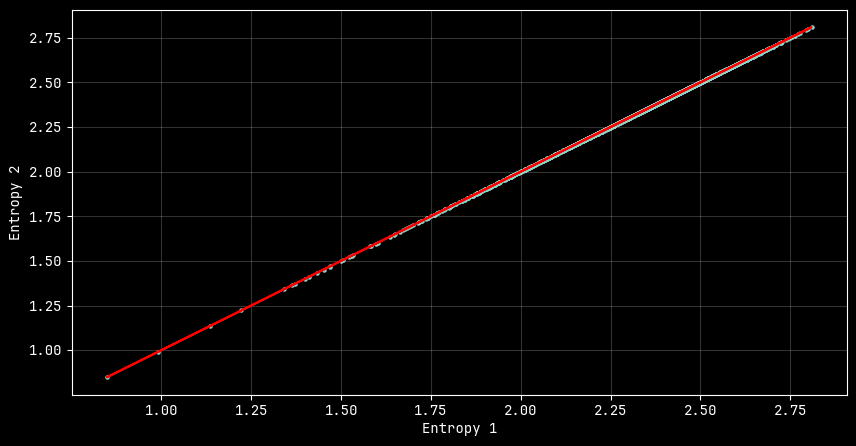

In [32]:
# test on a lot of tries
H1s, H2s = [], []
for _ in tqdm(range(2000)):
    # generate random frequencies
    fs = uni(0, N_SAMPLES/20, N_FREQS)
    As = uni(0, 1, N_FREQS)
    φs = uni(0, 2*π, N_FREQS)
    t = np.arange(N_SAMPLES)

    # generate the signal
    x = np.sum([As[i]*np.sin(2*π*fs[i]*t+φs[i]) for i in range(N_FREQS)], axis=0)

    # quantize the signal
    xq = quantize(x, EPSI)

    nlevels = int(1+2*np.ceil(np.max(np.abs(x))/EPSI))

    # measure entropy of the signal
    H1s.append(entropy(xq)) 

    # # H2
    # # convert the signal to a tensor
    # xqt = torch.tensor(xq/EPSI + nlevels//2, dtype=torch.int64)
    # #convert to a vector of 1-hot encoded values
    # xq_1hot = F.one_hot(xqt, num_classes=nlevels)
    # # calculate entropy 2 
    # h = hloss(xq_1hot.to(torch.float32).unsqueeze(0))/N_SAMPLES

    # tensorflow version
    xtf = tf.constant(x, dtype=tf.float32)
    h = quantized_entropy_loss(EPSI, b=10)(xtf)
    
    H2s.append(h)

H1s, H2s = np.array(H1s), np.array(H2s)

# get the best linear fit between H1s and H2s
A = np.vstack([H1s, np.ones(len(H1s))]).T
m, c = np.linalg.lstsq(A, H2s, rcond=None)[0]
print(f'best fit: y = {m:.2f}x + {c:.2f}')

plt.figure(figsize=(10, 5))
plt.scatter(H1s, H2s, s=5)
plt.plot(H1s, m*H1s + c, color='red')
plt.xlabel('Entropy 1')
plt.ylabel('Entropy 2')
plt.show()


In [33]:
# criterion = HLoss()
# x = Variable(torch.randn(10, 10))
# w = Variable(torch.randn(10, 3), requires_grad=True)
# output = torch.matmul(x, w)
# loss = criterion(output)
# loss.backward()
# print(w.grad)